# Time series forecasting

## Setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Daten laden

In [2]:
wetter_xlsx_path = 'Daten_Graz_2015-2019.xlsx'
xls = pd.ExcelFile(wetter_xlsx_path)

In [3]:
df_pm = xls.parse(0)[2:]
df_lufttemp = xls.parse(1)[3:]
df_luftfeucht = xls.parse(2)[3:]
df_luftdruck = xls.parse(3)[3:]
df_windrichtung = xls.parse(4)[3:]
df_mittel_wind = xls.parse(5)[3:]
df_max_wind = xls.parse(6)[3:]
df_globalstr = xls.parse(7)[3:]
df_niederschlag = xls.parse(8)[3:]

In [4]:
date_time = pd.to_datetime(df_pm.pop('Station:'), format='%d.%m.%Y %H:%M:%S')

Daten aus Excel in ein pandas Dataframe laden und Datum-Spalte in ein eigenens DF speichern

Zusammenbau des Dataframes (Alle für Training benutzten Daten)



=> ja

## Daten - PM10

Zusammenbau des Dataframes (Alle für Training benutzten Daten)

In [5]:
max_wind_date_time = pd.to_datetime(df_max_wind.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
windrichtung_date_time = pd.to_datetime(df_windrichtung.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
mittel_wind_date_time = pd.to_datetime(df_mittel_wind.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
niederschlag_date_time = pd.to_datetime(df_niederschlag.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
globalstr_date_time = pd.to_datetime(df_globalstr.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
luftdruck_date_time = pd.to_datetime(df_luftdruck.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
lufttemp_date_time = pd.to_datetime(df_lufttemp.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
luftfreucht_date_time = pd.to_datetime(df_luftfeucht.pop('Station:'), format='%d.%m.%Y %H:%M:%S')

In [6]:
df_lufttemp=df_lufttemp.astype('float')
df_lufttemp.index = df_lufttemp.index -1

df_luftdruck=df_luftdruck.astype('float')
df_luftdruck.index = df_luftdruck.index -1

df_luftfeucht=df_luftfeucht.astype('float')
df_luftfeucht.index = df_luftfeucht.index -1

df_globalstr=df_globalstr.astype('float')
df_globalstr.index = df_globalstr.index -1

df_niederschlag=df_niederschlag.astype('float')
df_niederschlag.index = df_niederschlag.index -1

df_mittel_wind=df_mittel_wind.astype('float')
df_mittel_wind.index = df_mittel_wind.index -1

df_windrichtung = df_windrichtung.astype('float')
df_windrichtung.index = df_windrichtung.index -1

df_max_wind=df_max_wind.astype('float')
df_max_wind.index = df_max_wind.index -1

Next look at the statistics of the dataset:

# Feature Engineering

## Zeit in Zahl ändern

In [7]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [8]:
timestamp_s.describe()

count    8.764800e+04
mean     1.498954e+09
std      4.554350e+07
min      1.420072e+09
25%      1.459513e+09
50%      1.498954e+09
75%      1.538396e+09
max      1.577837e+09
Name: Station:, dtype: float64

In [9]:
day = 24*60*60
year = (365.2425)*day
df_zeit = pd.DataFrame()
df_zeit['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_zeit['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_zeit['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_zeit['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

[(0.0, 48.0)]

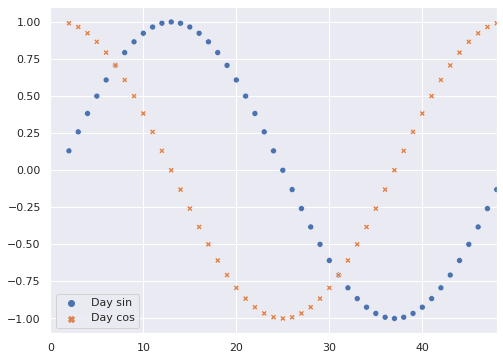

In [10]:
sns.set()
sns.set_style('darkgrid')

p1 = sns.scatterplot(data = df_zeit[df_zeit.columns[:2]])
p1.set(xlim=(0,48))


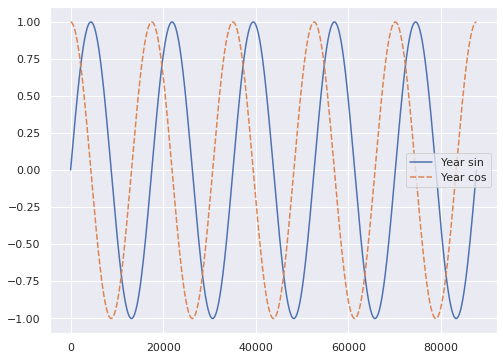

In [11]:
p2 = sns.lineplot(data = df_zeit[df_zeit.columns[2:]])


## PM - Löcher füllen
PM ohne Lustb. -> schauen bissl anderes aus als Rest von Graz
keine Werte außerhalb von Graz

In [12]:
df_durch = df_pm[
    ['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W']
].replace(0, np.NaN).T.mean().to_frame()


In [13]:
df_durch.isna().sum()

0    0
dtype: int64

In [14]:
df_pm.isna().sum() 

Graz-DB      478
Graz-M G     400
Graz-S      1700
Graz-O P     624
Graz-N       887
Graz-W       955
Lustb.       416
dtype: int64

In [15]:
df_pm[200:210]

,Graz-DB,Graz-M G,Graz-S,Graz-O P,Graz-N,Graz-W,Lustb.
202,6.3,4.8,12.2,8.4,6.7,2.3,NaN
203,8.5,4.7,7.6,9.1,6.5,2.3,NaN
204,8.3,4.5,8.4,10.2,6.7,3.4,NaN
205,8.1,3.8,12.2,11.8,7.5,5.4,NaN
206,8.8,3,16.7,12.9,9.4,6.2,NaN
207,9.5,4,20.7,13.4,13.5,5.8,NaN
208,10.7,5.2,20.5,16.8,15,4.9,NaN
209,11.8,7.9,19.3,21,10.9,3.3,NaN
210,15,10.7,21.3,22.4,9.7,5.3,NaN
211,18.2,13.8,24.2,22.6,14.1,10.1,NaN


In [16]:
df_pm[24499:25500].head()

,Graz-DB,Graz-M G,Graz-S,Graz-O P,Graz-N,Graz-W,Lustb.
24501,14.1,9.6,0,1.1,9.6,5,0
24502,NaN,10.6,0,2.1,9.7,5.1,0.1
24503,NaN,10,0,5.2,8.7,5.3,2.5
24504,12.6,9.4,0,10,8.1,7.2,8.5
24505,12.7,9.6,0,13.1,8.3,9.3,16.5


In [17]:
df_pm_all = df_pm.copy()
df_pm_all['durch'] = df_durch
df_pm_all.head()

,Graz-DB,Graz-M G,Graz-S,Graz-O P,Graz-N,Graz-W,Lustb.,durch
2,98.4,80.8,184.2,78.3,86.3,77.2,50,100.866667
3,88.7,180.2,396.2,122.7,108.2,94.7,56,165.116667
4,112.1,291.4,494.4,213.3,144.2,129.2,64.1,230.766667
5,135.8,251.4,426.8,254.7,207.3,176.9,83.8,242.150000
6,164,191.4,337.9,243.6,242.9,206.8,102.1,231.100000


In [18]:
df_pm_all = df_pm_all.T.apply(lambda s: 
                    s[:-1].map(
                        lambda x: s['durch'] if np.isnan(x) else x
                    )
                   ).T

In [19]:
df_pm_all[24499:25500].head()

,Graz-DB,Graz-M G,Graz-S,Graz-O P,Graz-N,Graz-W,Lustb.
24501,14.100,9.6,0.0,1.1,9.6,5.0,0.0
24502,6.875,10.6,0.0,2.1,9.7,5.1,0.1
24503,7.300,10.0,0.0,5.2,8.7,5.3,2.5
24504,12.600,9.4,0.0,10.0,8.1,7.2,8.5
24505,12.700,9.6,0.0,13.1,8.3,9.3,16.5


In [20]:
df_pm_all[200:210]

,Graz-DB,Graz-M G,Graz-S,Graz-O P,Graz-N,Graz-W,Lustb.
202,6.3,4.8,12.2,8.4,6.7,2.3,6.783333
203,8.5,4.7,7.6,9.1,6.5,2.3,6.450000
204,8.3,4.5,8.4,10.2,6.7,3.4,6.916667
205,8.1,3.8,12.2,11.8,7.5,5.4,8.133333
206,8.8,3.0,16.7,12.9,9.4,6.2,9.500000
207,9.5,4.0,20.7,13.4,13.5,5.8,11.150000
208,10.7,5.2,20.5,16.8,15.0,4.9,12.183333
209,11.8,7.9,19.3,21.0,10.9,3.3,12.366667
210,15.0,10.7,21.3,22.4,9.7,5.3,14.066667
211,18.2,13.8,24.2,22.6,14.1,10.1,17.166667


Keine Lücken

---

df_pm_all -> weiterarbeiten

## Rest - Löcher füllen
PM ohne Lustb. -> schauen bissl anderes aus als Rest von Graz
keine Werte außerhalb von Graz

### Temp

In [21]:
df_temp = df_lufttemp[['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W']]

In [22]:
df_temp['durchschnitt'] = df_temp.T.mean().to_frame()

<ipython-input-22-ea0c2576ba98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['durchschnitt'] = df_temp.T.mean().to_frame()


In [23]:
df_temp.isna().sum()

Graz-DB            10
Graz-M G          156
Graz-S            859
Graz-O P        41673
Graz-N            538
Graz-W             10
durchschnitt        0
dtype: int64

In [24]:
df_temp = df_temp.T.apply(lambda s: 
                    s[:-1].map(
                        lambda x: s['durchschnitt'] if np.isnan(x) else x
                    )
                   ).T

In [25]:
df_temp.isna().sum()

Graz-DB     0
Graz-M G    0
Graz-S      0
Graz-O P    0
Graz-N      0
Graz-W      0
dtype: int64

### Druck

In [26]:
df_druck = df_luftdruck[['Graz-N','Schöckl.1']]

<AxesSubplot:>

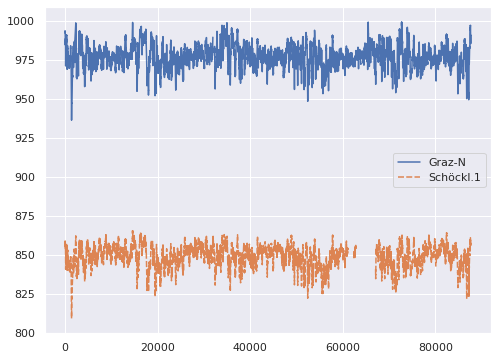

In [27]:
sns.lineplot(data = df_luftdruck[['Graz-N','Schöckl.1']])

In [28]:
df_druck.isna().sum()

Graz-N        538
Schöckl.1    6006
dtype: int64

In [29]:
leer = df_druck[['Graz-N']][df_druck['Graz-N'].isna()]

In [30]:
leer

,Graz-N
1648,NaN
3765,NaN
3766,NaN
5066,NaN
5211,NaN
...,...
70823,NaN
71205,NaN
73557,NaN
76244,NaN


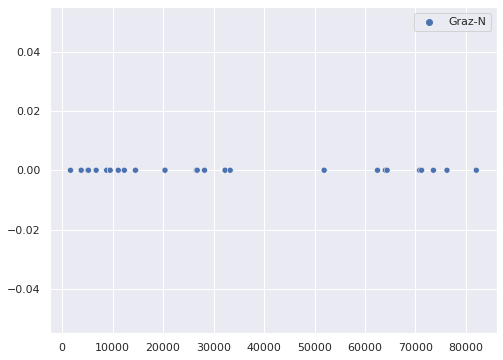

In [31]:
g = sns.scatterplot(data = leer.fillna(0))

In [32]:
leer_diff = leer.index.to_frame().diff()
leer_diff.describe().T

,count,mean,std,min,25%,50%,75%,max
0,537.0,149.733706,1099.100693,1.0,1.0,1.0,1.0,18586.0


#### Schaut nach großen Loch aus

In [33]:
leer_diff[leer_diff[0] < 10]

,0
3766,1.0
9513,2.0
14523,1.0
20372,1.0
26611,1.0
...,...
64042,1.0
64043,1.0
64044,1.0
64045,1.0


 leer_diff: wie groß ist abstand zwischen löchern
 
1: mehrer löcher hintereinander

\>1 interpolieren


---

Einzelne leer_diff sind auch egal

In [34]:
durchg = leer_diff[leer_diff[0] == 1].index.to_frame().diff()
durchg = durchg[durchg[0] == 1]

<AxesSubplot:>

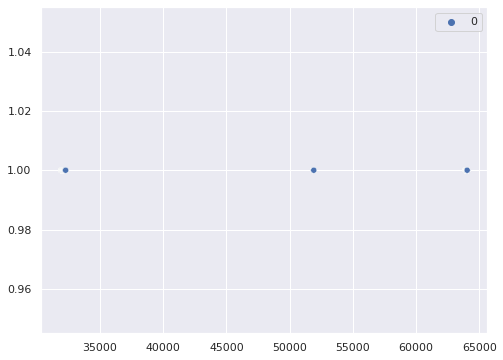

In [35]:
sns.scatterplot(data = durchg)

schaut aus nach 3 folgen von großen Löchern

durchg

In [36]:
f1 = durchg[durchg.index<40000].count()[0]
l1_a = durchg[durchg.index<40000].iloc[0].name - 4
l1_e = durchg[durchg.index<40000].iloc[-2].name

f2 = durchg[(durchg.index>40000) & (durchg.index<60000)].count()[0]
l2_a = durchg[(durchg.index>40000) & (durchg.index<60000)].iloc[0].name - 4
l2_e = durchg[(durchg.index>40000) & (durchg.index<60000)].iloc[-2].name

f3 = durchg[durchg.index>60000].count()[0]
l3_a = durchg[durchg.index>60000].iloc[0].name - 4
l3_e = durchg[durchg.index>60000].iloc[-2].name


In [37]:
df_druck[:l1_a] = df_druck[:l1_a].interpolate(method='polynomial', order=2)
df_druck[l1_e:l2_a] = df_druck[l1_e:l2_a].interpolate(method='polynomial', order=2)
df_druck[l2_e:l3_a] = df_druck[l2_e:l3_a].interpolate(method='polynomial', order=2)
df_druck[l3_e:] = df_druck[l3_e:].interpolate(method='polynomial', order=2)

<ipython-input-37-0825a7da89ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_druck[:l1_a] = df_druck[:l1_a].interpolate(method='polynomial', order=2)
/home/pmf/MachineLearning/venvs/cpu/lib/python3.8/site-packages/pandas/core/frame.py:3051: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer(key, value)
/home/pmf/MachineLearning/venvs/cpu/lib/python3.8/site-packages/pandas/core/frame.py:3036: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

=>  3 Löcher in Druck


In [38]:
druck_c = df_druck[['Graz-N']].copy()
druck_c.index = luftdruck_date_time

<AxesSubplot:xlabel='Station:'>

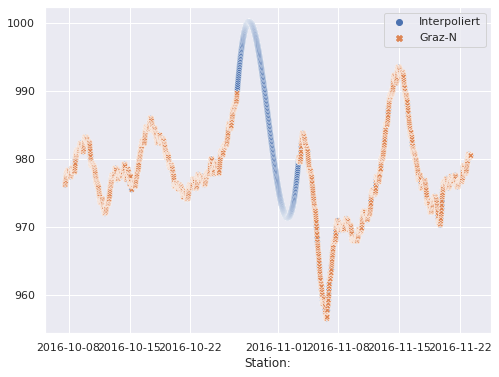

In [39]:
sns.scatterplot(
    data = druck_c[l1_a-950:l1_e+950]
          .interpolate(method='polynomial', order=3)
          .rename(columns={'Graz-N':'Interpoliert'}).join(druck_c[l1_a-950:l1_e+950])
)

In [40]:
df_druck.update(
    df_druck[l1_a-950:l1_e+950].interpolate(method='polynomial', order=3)
)

/home/pmf/MachineLearning/venvs/cpu/lib/python3.8/site-packages/pandas/core/frame.py:6397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


<AxesSubplot:xlabel='Station:'>

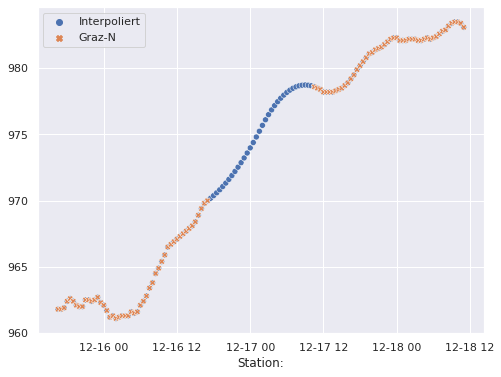

In [41]:
sns.scatterplot(
    data = druck_c[l2_a-50:l2_e+50]
          .interpolate(method='polynomial', order=2)
          .rename(columns={'Graz-N':'Interpoliert'}).join(druck_c[l2_a-50:l2_e+50])
)

In [42]:
df_druck.update(
    df_druck[l2_a-50:l2_e+50].interpolate(method='polynomial', order=2))

/home/pmf/MachineLearning/venvs/cpu/lib/python3.8/site-packages/pandas/core/frame.py:6397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


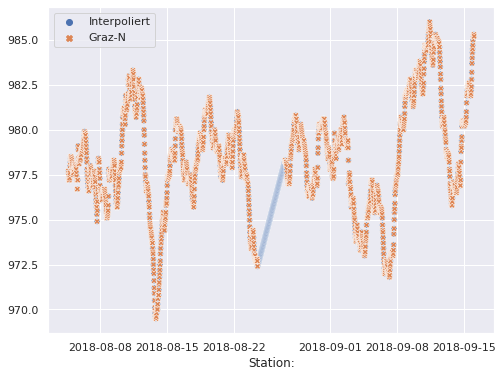

In [43]:
g = sns.scatterplot(
    data = druck_c[l3_a-950:l3_e+950]
          .interpolate(method='linear')
          .rename(columns={'Graz-N':'Interpoliert'}).join(druck_c[l3_a-950:l3_e+950])
)


In [44]:
df_druck.update(
    df_druck[l3_a-950:l3_e+950].interpolate(method='linear'))

/home/pmf/MachineLearning/venvs/cpu/lib/python3.8/site-packages/pandas/core/frame.py:6397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [45]:
df_druck = df_druck[['Graz-N']]

In [46]:
df_druck.isna().sum()

Graz-N    0
dtype: int64

### Feuchtigkeit

In [47]:
df_feucht = df_luftfeucht[['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-N', 'Graz-W',
       'Lustb.']]

In [48]:
df_feucht['durchschnitt'] = df_feucht.T.mean().to_frame()

<ipython-input-48-a9c9d6cbc94b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feucht['durchschnitt'] = df_feucht.T.mean().to_frame()


In [49]:
df_feucht.isna().sum()

Graz-DB          10
Graz-M G        157
Graz-S          273
Graz-N          538
Graz-W          168
Lustb.           13
durchschnitt      0
dtype: int64

In [50]:
df_feucht = df_feucht.T.apply(lambda s: 
                    s[:-1].map(
                        lambda x: s['durchschnitt'] if np.isnan(x) else x
                    )
                   ).T

In [51]:
df_feucht.isna().sum()

Graz-DB     0
Graz-M G    0
Graz-S      0
Graz-N      0
Graz-W      0
Lustb.      0
dtype: int64

### Globalstrahlung

In [52]:
name = 'Globalstrahlung'

In [53]:
df_global = df_globalstr[['Graz-N']]

In [54]:
df_global.isna().sum()

Graz-N    1572
dtype: int64

In [55]:
leer = df_global[['Graz-N']][df_global['Graz-N'].isna()]

<AxesSubplot:>

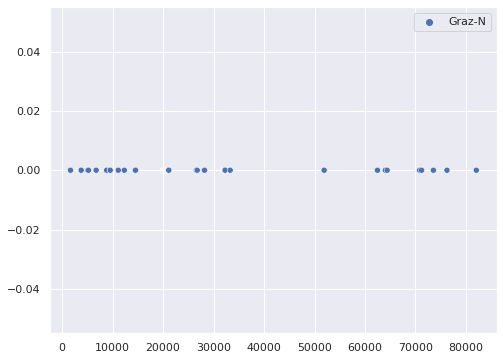

In [56]:
sns.scatterplot(data = leer.fillna(0))

In [57]:
leer_diff = leer.index.to_frame().diff()
leer_diff.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1571.0,51.18205,640.152484,1.0,1.0,1.0,1.0,18586.0


#### Löcher

In [58]:
leer_diff[leer_diff[0] < 10]

,0
3766,1.0
9513,2.0
14523,1.0
20086,1.0
20087,1.0
...,...
64042,1.0
64043,1.0
64044,1.0
64045,1.0


 leer_diff: wie groß ist abstand zwischen löchern
 
1: mehrer löcher hintereinander

\>1 interpolieren


---

Einzelne leer_diff sind auch egal

In [59]:
durchg = leer_diff[leer_diff[0] == 1].index.to_frame().diff()
durchg = durchg[durchg[0] == 1]

In [60]:
durchg.count()

0    1536
dtype: int64

<AxesSubplot:>

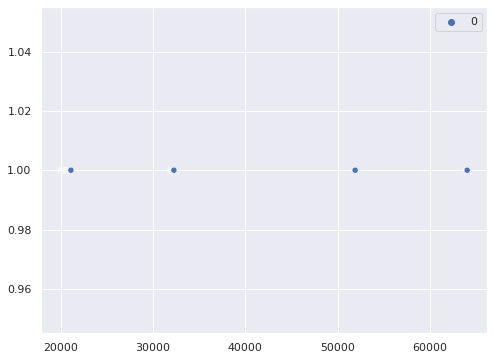

In [61]:
sns.scatterplot(data = durchg)

schaut aus nach 4 folgen von großen Löchern

durchg

In [62]:
f1 = durchg[durchg.index<25000].count()[0] #.astype('int')
l1_a = durchg[durchg.index<25000].iloc[0].name - 4
l1_e = durchg[durchg.index<25000].iloc[-2].name


In [63]:
f2 = durchg[(durchg.index>30000) & (durchg.index<40000)].count()[0]
l2_a = durchg[(durchg.index>30000) & (durchg.index<40000)].iloc[0].name - 4
l2_e = durchg[(durchg.index>30000) & (durchg.index<40000)].iloc[-2].name

In [64]:
f3 = durchg[(durchg.index>40000) & (durchg.index<60000)].count()[0]
l3_a = durchg[(durchg.index>40000) & (durchg.index<60000)].iloc[0].name - 4
l3_e = durchg[(durchg.index>40000) & (durchg.index<60000)].iloc[-2].name

In [65]:
f4 = durchg[durchg.index>60000].count()[0] + 4
l4_a = durchg[durchg.index>60000].iloc[0].name - 4
l4_e = durchg[durchg.index>60000].iloc[-2].name

In [66]:
f = f1+f2+f3+f4
f, f1, f2, f3, f4

(1540, 1035, 337, 32, 136)

=>  4 Löcher in Druck

---



In [67]:
glob_c = df_global[['Graz-N']].copy()
glob_c.index = globalstr_date_time

<AxesSubplot:xlabel='Station:'>

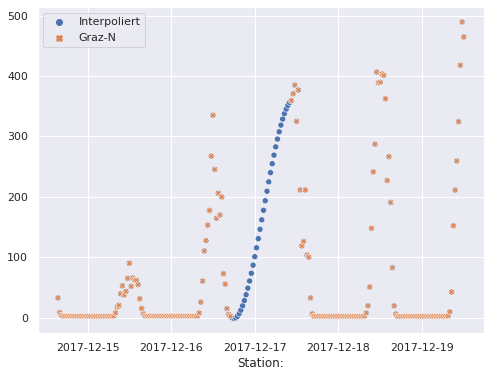

In [68]:
sns.scatterplot(
    data = glob_c[l3_a-100:l3_e+100]
          .interpolate(method='polynomial', order=3)
          .rename(columns={'Graz-N':'Interpoliert'}).join(glob_c)
)

#### nur 3. loch interpololierbar

In [69]:
df_global.update( df_global[:l1_a].interpolate(method='polynomial', order=2) )
df_global.update( df_global[l1_e:l2_a].interpolate(method='polynomial', order=2) )
df_global.update( df_global[l2_e:l3_a].interpolate(method='polynomial', order=2) )
df_global.update( df_global[l3_e:l4_a].interpolate(method='polynomial', order=2) )
df_global.update( df_global[l4_e:].interpolate(method='polynomial', order=2) )

/home/pmf/MachineLearning/venvs/cpu/lib/python3.8/site-packages/pandas/core/frame.py:6397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [70]:
df_global.update(df_global[l3_a-100:l3_e+100].interpolate(method='polynomial', order=3))

In [71]:
df_global.isna().sum()

Graz-N    1512
dtype: int64

#### andere Jahre nachschauen

Nachdem Globalstrahlung abhängig von Zeit und Jahr ist 

In [72]:
teil = df_global.count().max()//5

<AxesSubplot:xlabel='Station:'>

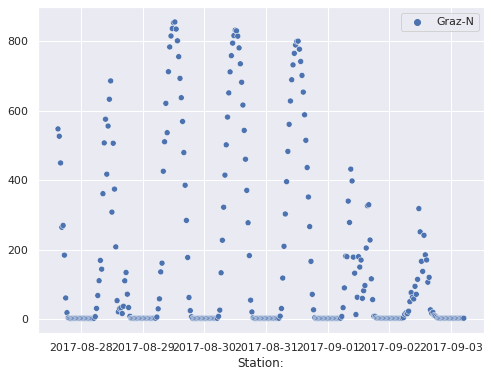

In [73]:
sns.scatterplot(
    data = glob_c[l4_a-teil-140:l4_e+40-teil])

In [74]:
glob_c['Aufgefüllt'] = np.NaN
glob_c['Aufgefüllt'][l1_a:l1_e] = glob_c[l1_a+teil:l1_e+teil]['Graz-N'].values
glob_c['Aufgefüllt'][l2_a:l2_e] = glob_c[l2_a+teil:l2_e+teil]['Graz-N'].values
glob_c['Aufgefüllt'][l4_a:l4_e] = glob_c[l4_a-teil:l4_e-teil]['Graz-N'].values

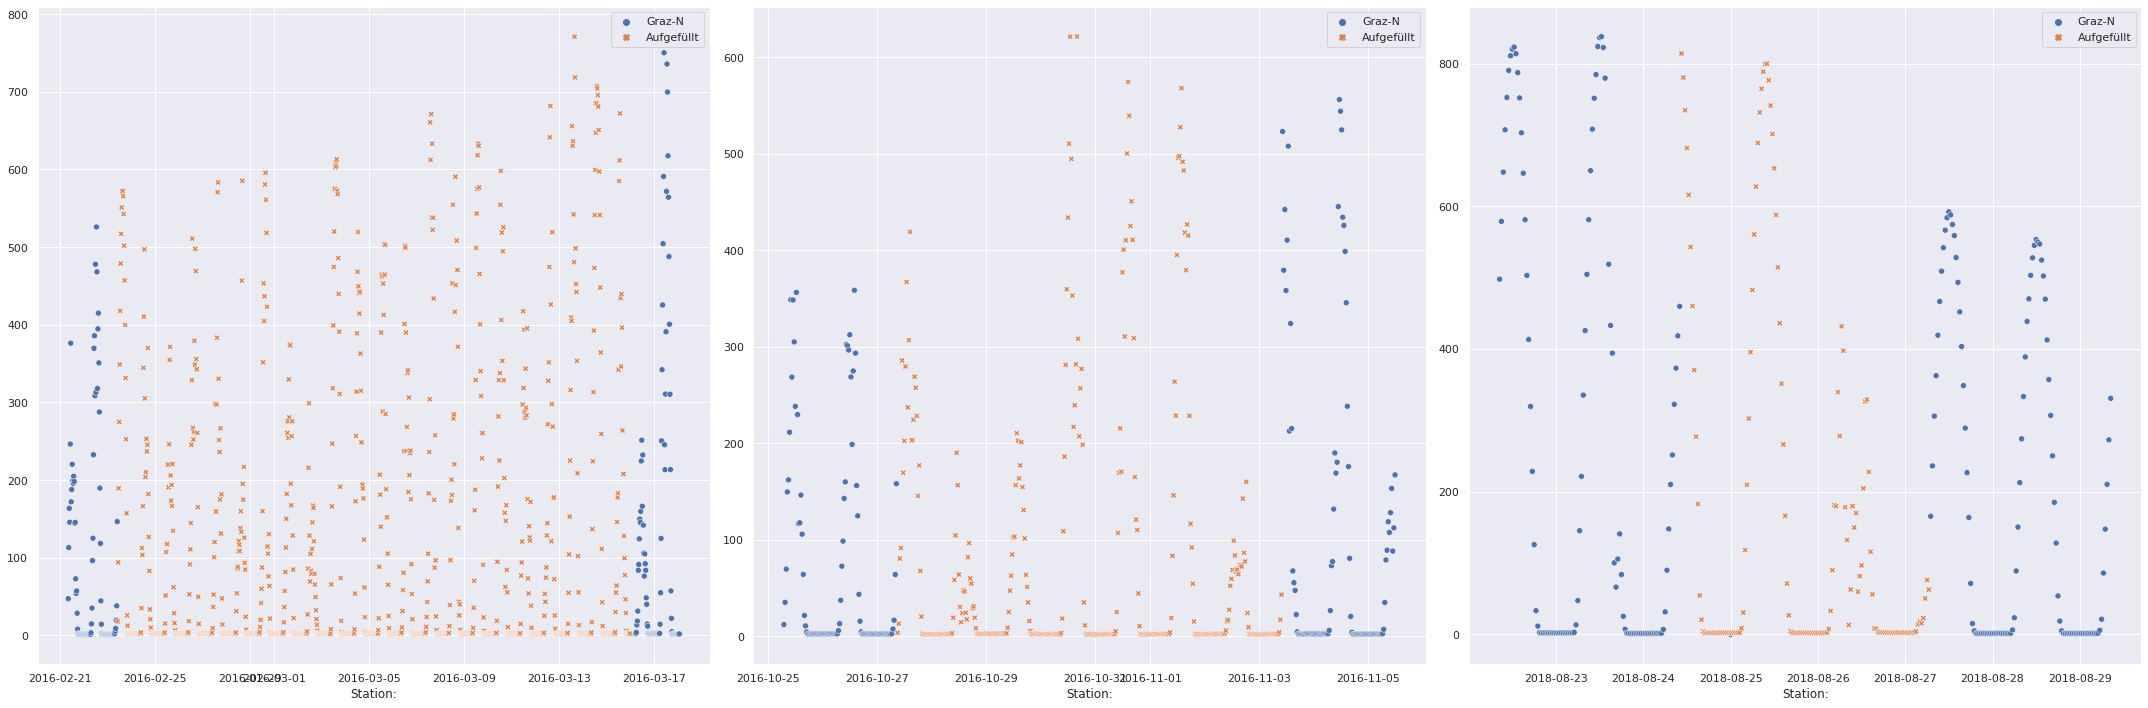

In [75]:
glob_c.index = globalstr_date_time

fig, axs = plt.subplots(ncols=3, figsize=(30,10))

sns.scatterplot(data = glob_c[l1_a-100:l1_e+100], ax=axs[0])
sns.scatterplot(data = glob_c[l2_a-100:l2_e+100], ax=axs[1])
sns.scatterplot(data = glob_c[l4_a-100:l4_e+100], ax=axs[2])



fig.tight_layout()

fig.show()

In [76]:
pd.DataFrame(glob_c.T.sum().values)

,0
0,1.6
1,1.8
2,1.8
3,1.8
4,1.8
...,...
87643,2.5
87644,2.4
87645,2.7
87646,2.5


In [77]:
df_global['Graz-N'] = glob_c.T.sum().values

<ipython-input-77-a0156ee8aa90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global['Graz-N'] = glob_c.T.sum().values


In [78]:
df_global.isna().sum()

Graz-N    0
dtype: int64

### Niederschlag

In [79]:
name = 'Niederschlag'

In [80]:
df_nieder = df_niederschlag[['Graz-N','Schöckl.1']]

In [81]:
df_nieder['durchschnitt'] = df_nieder.T.mean().to_frame()

<ipython-input-81-21bc38237575>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nieder['durchschnitt'] = df_nieder.T.mean().to_frame()


In [82]:
df_nieder.isna().sum()

Graz-N           550
Schöckl.1       6036
durchschnitt     142
dtype: int64

In [83]:
df_nieder = df_nieder.T.apply(lambda s: 
                    s[:-1].map(
                        lambda x: s['durchschnitt'] if np.isnan(x) else x
                    )
                   ).T

In [84]:
df_nieder.isna().sum()

Graz-N       142
Schöckl.1    142
dtype: int64

In [85]:
df_nieder = df_nieder[['Graz-N']]

In [86]:
leer = df_nieder[['Graz-N']][df_nieder['Graz-N'].isna()]
leer_diff = leer.index.to_frame().diff()
durchg = leer_diff[leer_diff[0] == 1].index.to_frame().diff()
durchg = durchg[durchg[0] == 1]

Wieder ein Loch zwischen 

df_nieder[63908:64045]

In [87]:
loch_a = 63908
loch_e = 64045

In [88]:
df_nieder.update(df_nieder[:loch_a].interpolate(method='polynomial', order=2))
df_nieder.update(df_nieder[loch_e:].interpolate(method='polynomial', order=2))

In [89]:
df_nieder.isna().sum()

Graz-N    137
dtype: int64

In [90]:
df_nieder = df_nieder[['Graz-N']]

#### Loch mit andere Daten füllen


In [91]:
teil = df_nieder.count().max()//5

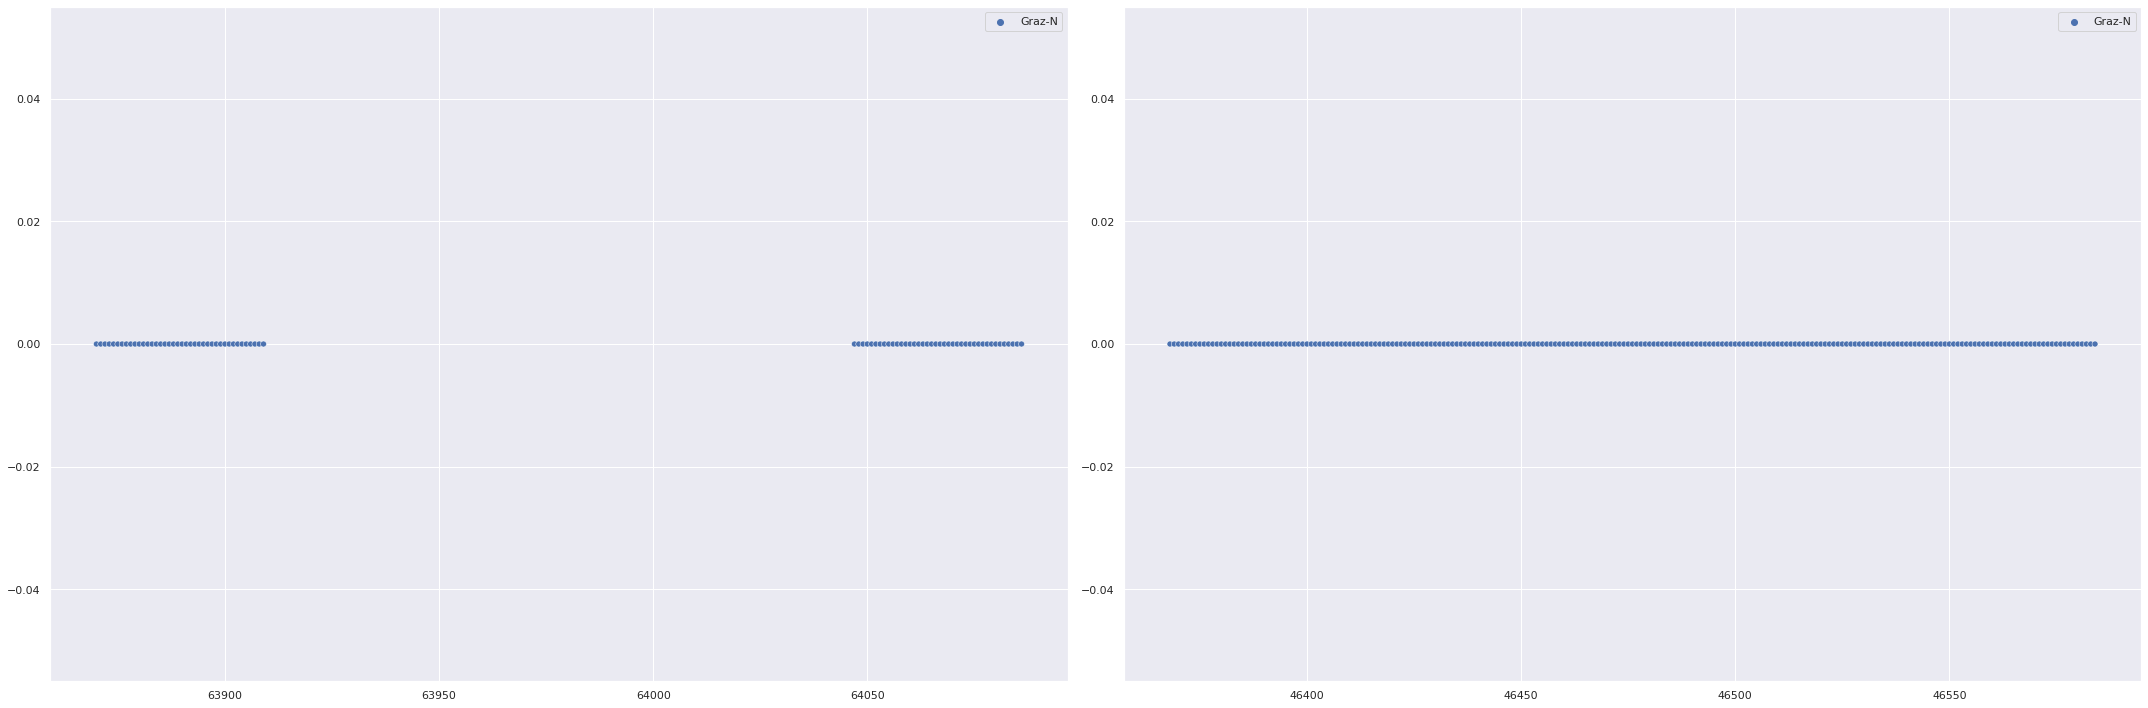

In [92]:
fig, axs = plt.subplots(ncols=2, figsize=(30,10))

sns.scatterplot(data = df_nieder[loch_a-40-teil:loch_e+40-teil], ax=axs[1])
sns.scatterplot(data = df_nieder[loch_a-40:loch_e+40], ax=axs[0])


fig.tight_layout()

fig.show()


In [93]:
df_nieder[loch_a-40:loch_e+40] = df_nieder[loch_a-40-teil:loch_e+40-teil].values

In [94]:
df_nieder.isna().sum()

Graz-N    0
dtype: int64

### Wind

In [95]:
df_wind = df_mittel_wind[['Graz-S',  'Graz-N', 'Graz-W']].add_suffix('_Mittel')
#df_wind = df_wind.join( df_max_wind[[ 'Graz-S', 'Graz-N', 'Graz-W']].add_suffix('_Max') )
df_wind_h = df_max_wind[['Graz-S',  'Graz-N', 'Graz-W']].add_suffix('_Max')


In [96]:
df_wind['durchschnitt'] = df_wind.T.mean().to_frame()
df_wind_h['durchschnitt'] = df_wind_h.T.mean().to_frame()

In [97]:
df_wind.isna().sum()

Graz-S_Mittel    276
Graz-N_Mittel    539
Graz-W_Mittel     15
durchschnitt       0
dtype: int64

In [98]:
df_wind = df_wind.T.apply(lambda s: 
                    s[:-1].map(
                        lambda x: s['durchschnitt'] if np.isnan(x) else x
                    )
                   ).T
df_wind_h = df_wind_h.T.apply(lambda s: 
                    s[:-1].map(
                        lambda x: s['durchschnitt'] if np.isnan(x) else x
                    )
                   ).T

In [99]:
df_wind_h.isna().sum()

Graz-S_Max    0
Graz-N_Max    0
Graz-W_Max    0
dtype: int64

In [100]:
df_wind = df_wind.join(df_wind_h)

### Windrichtung

 ->> bissl Problematischer weil duchschnitt von Grad nicht wirklich exakt sind
 
 durchschnitt aus 0 und 359 ist nicht bei 180!!!

In [101]:
df_wind_r = df_windrichtung[['Graz-S',  'Graz-N', 'Graz-W']]

In [102]:
leer = df_wind_r[['Graz-N']][df_wind_r['Graz-N'].isna()]
leer_diff = leer.index.to_frame().diff()
durchg = leer_diff[leer_diff[0] == 1].index.to_frame().diff()
durchg = durchg[durchg[0] == 1]

<AxesSubplot:>

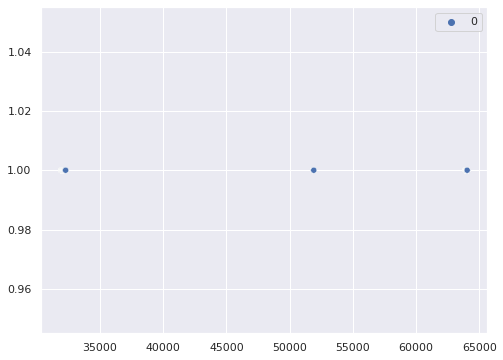

In [103]:
sns.scatterplot(data=durchg)

In [104]:
f1 = durchg[durchg.index<40000].count()[0] #.astype('int')
l1_a = durchg[durchg.index<40000].iloc[0].name - 4
l1_e = durchg[durchg.index<40000].iloc[-2].name

f2 = durchg[(durchg.index>40000) & (durchg.index<60000)].count()[0]
l2_a = durchg[(durchg.index>40000) & (durchg.index<60000)].iloc[0].name - 4
l2_e = durchg[(durchg.index>40000) & (durchg.index<60000)].iloc[-2].name

f3 = durchg[durchg.index>60000].count()[0] #.astype('int')
l3_a = durchg[durchg.index>60000].iloc[0].name - 4
l3_e = durchg[durchg.index>60000].iloc[-2].name

In [105]:
df_wind_r.update(df_wind_r[:l1_a].interpolate(method='polynomial', order=1))
df_wind_r.update(df_wind_r[l1_e:l2_a].interpolate(method='polynomial', order=1))
df_wind_r.update(df_wind_r[l2_e:l3_a].interpolate(method='polynomial', order=1))
df_wind_r.update(df_wind_r[l4_e:].interpolate(method='polynomial', order=1))

/home/pmf/MachineLearning/venvs/cpu/lib/python3.8/site-packages/pandas/core/frame.py:6397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [106]:
df_wind_r[l1_a-14:l1_e+40].isna().sum()

Graz-S      0
Graz-N    339
Graz-W      0
dtype: int64

In [107]:
df_wind_r = df_wind_r[['Graz-N']]

In [108]:
df_wind_r.isna().sum()

Graz-N    510
dtype: int64

#### andere Jahre nachschauen

Nachdem Globalstrahlung abhängig von Zeit und Jahr ist 

In [109]:
teil = df_wind_r.count().max()//5

<AxesSubplot:>

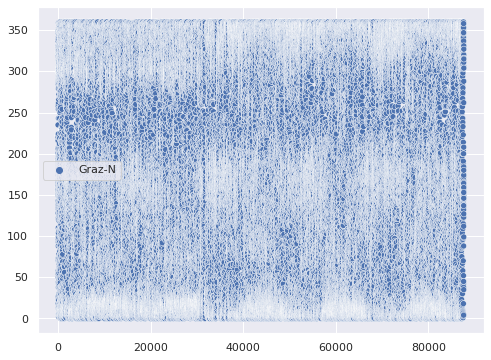

In [110]:
sns.scatterplot(
    data = df_wind_r)

In [111]:
df_wind_r['Aufgefüllt'] = np.NaN
df_wind_r['Aufgefüllt'][l1_a:l1_e] = df_wind_r[l1_a+teil:l1_e+teil]['Graz-N'].values
df_wind_r['Aufgefüllt'][l2_a:l2_e] = df_wind_r[l2_a+teil:l2_e+teil]['Graz-N'].values
df_wind_r['Aufgefüllt'][l3_a:l3_e] = df_wind_r[l3_a-teil:l3_e-teil]['Graz-N'].values

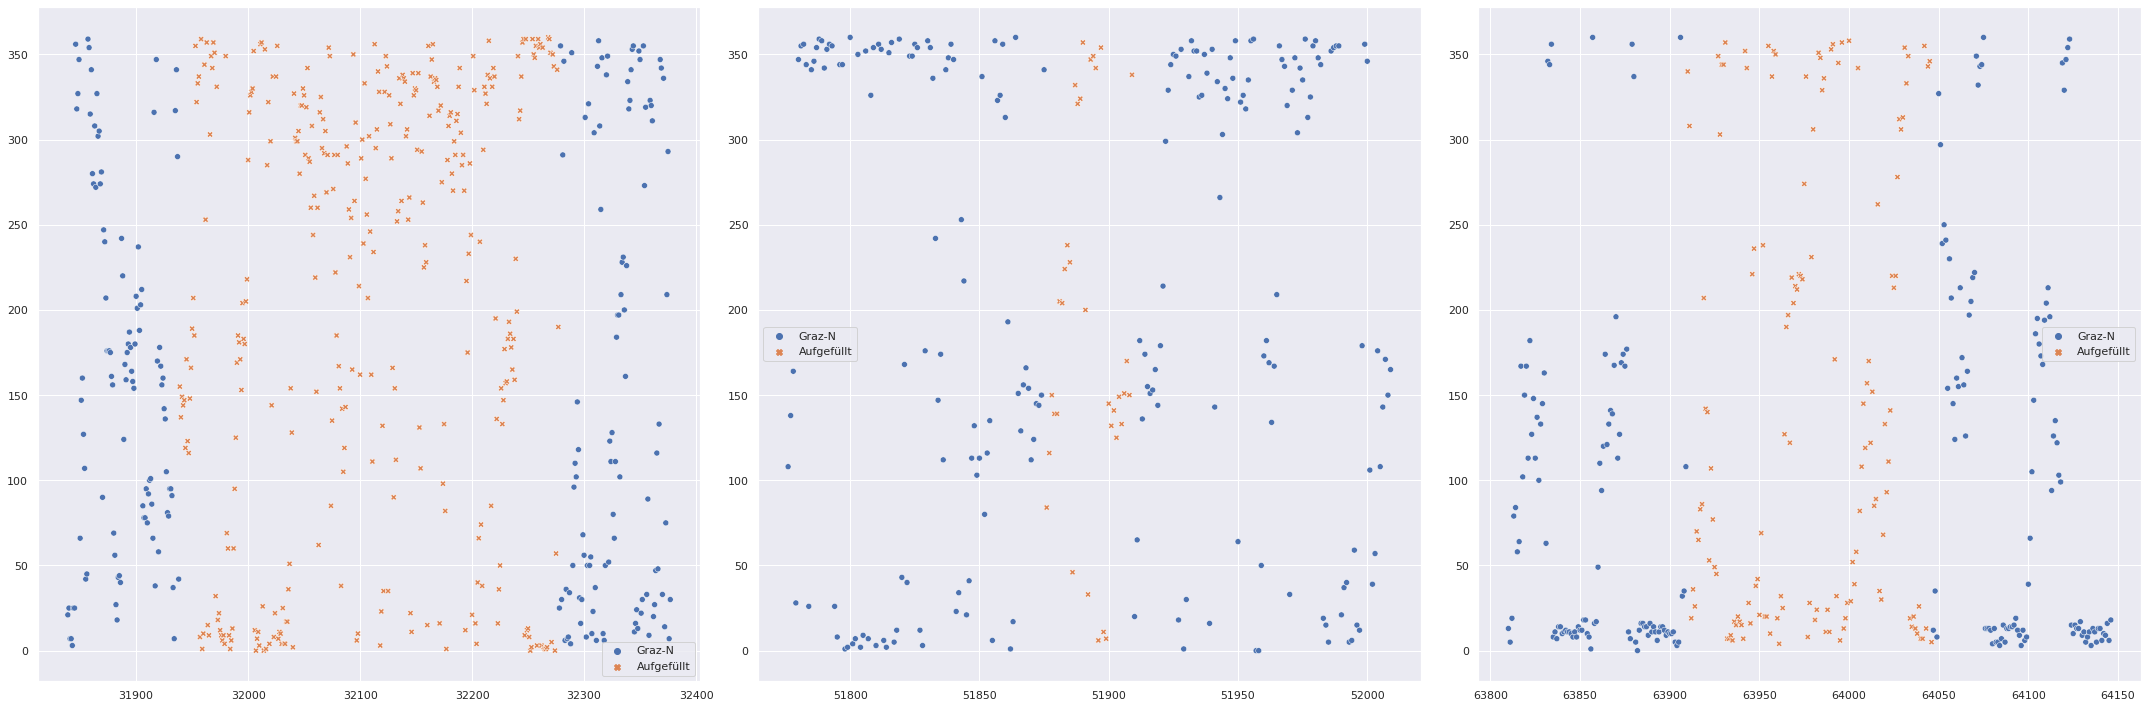

In [112]:
glob_c.index = globalstr_date_time

fig, axs = plt.subplots(ncols=3, figsize=(30,10))

sns.scatterplot(data = df_wind_r[l1_a-100:l1_e+100], ax=axs[0])
sns.scatterplot(data = df_wind_r[l2_a-100:l2_e+100], ax=axs[1])
sns.scatterplot(data = df_wind_r[l3_a-100:l3_e+100], ax=axs[2])



fig.tight_layout()

fig.show()


In [113]:
df_wind_r['Graz-N'] = df_wind_r.T.sum().values

In [114]:
df_wind_r = df_wind_r[['Graz-N']]

In [115]:
df_wind_r.isna().sum()

Graz-N    0
dtype: int64

In [116]:
df_wind.columns

Index(['Graz-S_Mittel', 'Graz-N_Mittel', 'Graz-W_Mittel', 'Graz-S_Max',
       'Graz-N_Max', 'Graz-W_Max'],
      dtype='object')

In [118]:
wv = df_wind[['Graz-N_Mittel']]
max_wv = df_wind[['Graz-N_Max']]

wv = wv.rename(columns={'Graz-N_Mittel': 'Graz-N'})
max_wv = max_wv.rename(columns={'Graz-N_Max': 'Graz-N'})

df_wind_xz = pd.DataFrame()

# Convert to radians.
wd_rad = df_wind_r[['Graz-N']]*np.pi / 180

df_wind['Wx'] = wv*np.cos(wd_rad.astype(float))
df_wind['Wy'] = wv*np.sin(wd_rad.astype(float))

df_wind['max Wx'] = max_wv*np.cos(wd_rad.astype(float))
df_wind['max Wy'] = max_wv*np.sin(wd_rad.astype(float))

In [119]:
df_wind.columns

Index(['Graz-S_Mittel', 'Graz-N_Mittel', 'Graz-W_Mittel', 'Graz-S_Max',
       'Graz-N_Max', 'Graz-W_Max', 'Wx', 'Wy', 'max Wx', 'max Wy'],
      dtype='object')

# Auswahl Daten

In [120]:
df = df_pm_all[['Graz-N']]

In [121]:
df['Temp'] = df_temp['Graz-N']
df['Druck'] = df_druck['Graz-N']
df['Global'] = df_global['Graz-N']
df['Feucht'] = df_feucht['Graz-N']
df['Nieders'] = df_nieder['Graz-N']

<ipython-input-121-4e67796606d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temp'] = df_temp['Graz-N']
<ipython-input-121-4e67796606d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Druck'] = df_druck['Graz-N']
<ipython-input-121-4e67796606d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [122]:
df = df.join(df_wind[['Graz-N_Mittel', 'Graz-N_Max',  'Wx', 'Wy', 'max Wx', 'max Wy']])

In [123]:
df = df.join(df_zeit)

In [124]:
df['zeit_in_s'] = timestamp_s

## Korrelationen

In [125]:
df.corrwith(df['Graz-N'])

Graz-N           1.000000
Temp            -0.266271
Druck            0.172769
Global           0.001075
Feucht           0.070568
Nieders         -0.052937
Graz-N_Mittel   -0.059650
Graz-N_Max      -0.156913
Wx              -0.182572
Wy               0.096627
max Wx          -0.203175
max Wy           0.114327
Day sin         -0.071454
Day cos         -0.065663
Year sin         0.092669
Year cos         0.341729
zeit_in_s       -0.110925
dtype: float64

In [126]:
df.corrwith(df['Graz-N'], method='spearman')

Graz-N           1.000000
Temp            -0.206100
Druck            0.187841
Global           0.014917
Feucht           0.050589
Nieders         -0.151284
Graz-N_Mittel   -0.023086
Graz-N_Max      -0.169248
Wx              -0.185621
Wy               0.135335
max Wx          -0.227676
max Wy           0.144567
Day sin         -0.049909
Day cos         -0.083451
Year sin         0.062330
Year cos         0.319079
zeit_in_s       -0.097237
dtype: float64

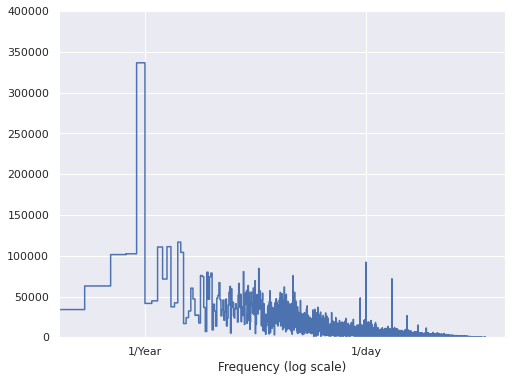

In [127]:
fft = tf.signal.rfft(df['Graz-N'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Graz-N'])
half_hours_per_year = 48*365.2524
years_per_dataset = n_samples_h/(half_hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

**Bewertung:** Korrelationen der einzelnen Features mit dem PM10 Wert sind sehr niedrig. Die Wahrscheinlichkeit, dass sie ein Modell zum positiven beeinflussen ist gering.
Aus Plots der PM10 Werte über die Zeit (siehe erstes Notebook), sowie aus dem letzten Plot (Frequenzabhängigkeit) ist zu schließen, dass Jahr und Tag den größten Einfluss auf die PM10 Werte haben.

## Features hinzufügen

**Kurzerklärung:** In diesem, für die Abgabe gedachten Notebook werden laut Korrelationsanalyse nur die Features PM10 Graz-N (Label), Day sin und cos, Year sin und cos verwendet.

Die Vorgehensweise bei der Entwicklung war, alle feature-engineerten Daten in einer Mongo-DB zwischenzuspeichern um flexibel und schnell unterschiedliche Modelle mit unterschiedlichen Features testen zu können. Die Ergebnisse von Modellen mit zusätzlichen Features weisen auf die Richtigkeit der Korrelationsanalyse hin. Mit den zur Verfügung stehenden Wetterdaten ist es somit nicht möglich ein deutlich besseres Modell zu trainieren als mit den hier gewählten Features.

**Ergebnisse anderer Modelle:**

Vergleich der einzelnen Stationen (nur PM10 Werte). Jeweils getestet mit vier Modellen:

- Baseline: Die Vorhersage entspricht dem Wert von vor 6 Stunden.
- LSTM 32: LSTM Netz mit einem Layer mit 32 Neuronen.
- LSTM 64: LSTM Netz mit einem Layer mit 64 Neuronen.
- LSTM 32+16: LSTM Netz mit zwei Layern.

| Modell | Graz-N | Graz-DB | Graz-S | Graz-O P | Lustb | Graz-W |
| --- | --- | --- | --- | --- | --- | --- |
| **Baseline** |   0.5529 | 0.5644 | 0.5139 | 0.6081 | 0.5014 | 0.5093 |
| **LSTM 32** |    0.3903 | 0.4122 | 0.3940 | 0.4146 | 0.3605 | 0.3773 |
| **LSTM 64** |    0.3872 | 0.3987 | 0.3917 | 0.4113 | 0.3589 | 0.3563 |
| **LSTM 32+16** | 0.3940 | 0.4035 | 0.3707 | 0.4223 | 0.3619 | 0.3788 |

Wie im letzten Abschnitt des letzten Notebooks ersichtlich, sind für die Station Graz-N die meisten Werte verfügbar, weshalb die nächsten Tests ausschließlich mit dem PM10 Wert plus einem weiteren Feature erfolten.

| Modell | Druck | Strahlung | Year sin, cos | Wind Max | Temperatur | Zeit (Sekunden) | Wind Mittel | Niederschlag |
| ------ | ----- | --------- | ------------- | -------- | ---------- | --------------- | ----------- | ------------ |
| Baseline |  0.5529 | 0.5529 | 0.5529 | 0.5529 | 0.5529 | 0.5529 | 0.5529 | 0.5529 |
| LSTM 32 |   0.3939 | 0.3805 | 0.4140 | 0.3821 | 0.3882 | 0.4124 | 0.4062 | 0.3886 |
| LSTM 64 |   0.3944 | 0.3780 | 0.4088 | 0.3845 | 0.3886 | 0.4005 | 0.4048 | 0.3898 |
| LSTM 32+16 |0.4082 | 0.3793 | 0.4132 | 0.3905 | 0.3977 | 0.4217 | 0.4136 | 0.3944 |

Aus den Werten ist zu sehen, dass es kein Feature zu einer Verbesserung des Modells führt. Das selbe gilt auch, wenn man mehrere Features kombiniert.

Das Modell, das in diesem Notebook trainiert wird nimmt nur Features entgegen, welche bereits in der Laufzeitumgebung integriert sind, da kein anderes zu einer erheblichen Verbesserung der Vorhersagequalität führen würde.

In [128]:
df.columns

Index(['Graz-N', 'Temp', 'Druck', 'Global', 'Feucht', 'Nieders',
       'Graz-N_Mittel', 'Graz-N_Max', 'Wx', 'Wy', 'max Wx', 'max Wy',
       'Day sin', 'Day cos', 'Year sin', 'Year cos', 'zeit_in_s'],
      dtype='object')

Ab hier kann die Auswahl für etwaige andere Modelle angepasst werden.

In [129]:
label_ziel = 'Graz-N'

In [130]:
feature_auswahl = ['Graz-N', 'Day sin', 'Day cos', 'Year sin', 'Year cos']

In [131]:
df_auswahl = df[feature_auswahl]

In [132]:
Stunden = 6

# Trainingsvorbereitung



## Teilen in Trainings-, Validierungs und Testdaten

In [133]:
column_indices = {name: i for i, name in enumerate(df_auswahl.columns)}

n = len(df_auswahl)
train_df = df_auswahl[0:int(n*0.7)]
val_df = df_auswahl[int(n*0.7):int(n*0.9)]
test_df = df_auswahl[int(n*0.9):]

num_features = df_auswahl.shape[1]

Speichern der Durchschnittswerte und Standardabweichungen für die Trainingsdaten: Zur Verwendung in der Runtime

In [134]:
train_mean = train_df.mean()
train_std = train_df.std()
file1 = open("EA2_values.txt","w+") 
file1.write(train_mean.to_string())
file1.write('\n')
file1.write(train_std.to_string())
file1.close()

### Daten normalisieren

Skalieren der Daten um Priorisierungsprobleme zu vermeiden und fehlende Werte durch 0 ersetzen.

In [135]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df = train_df.fillna(0)
val_df = val_df.fillna(0)
test_df = test_df.fillna(0)

Visualisierung der Daten in Abhängigkeit der Trainingsdaten

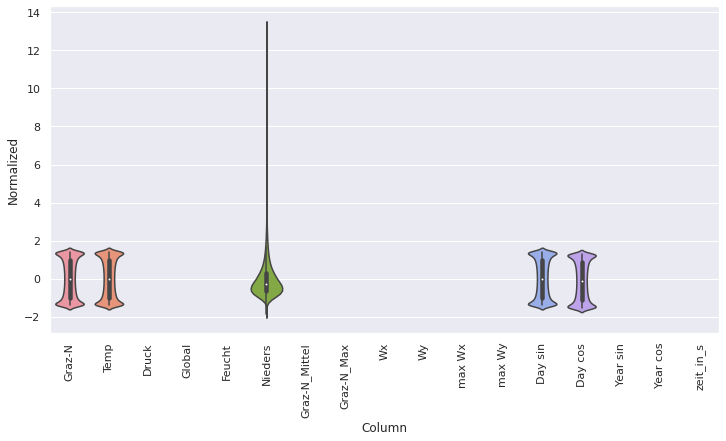

In [136]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

nur wenige starke Ausreisser

In [137]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Graz-N,87648.0,2.122419e+01,1.533114e+01,-8.900000e+00,1.140000e+01,1.760000e+01,2.660000e+01,2.429000e+02
Temp,87648.0,1.155019e+01,8.675590e+00,-1.500000e+01,4.700000e+00,1.140000e+01,1.810000e+01,3.690000e+01
Druck,87648.0,9.773519e+02,7.420712e+00,9.365000e+02,9.730000e+02,9.774000e+02,9.818000e+02,1.000194e+03
Global,87648.0,1.511321e+02,2.388410e+02,0.000000e+00,2.300000e+00,7.000000e+00,2.174000e+02,1.116000e+03
Feucht,87648.0,7.246821e+01,1.797022e+01,2.500000e+01,5.600000e+01,7.500000e+01,8.900000e+01,9.900000e+01
Nieders,87648.0,4.040781e-02,3.498597e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.682000e+01
Graz-N_Mittel,87648.0,7.481893e-01,6.088870e-01,0.000000e+00,3.000000e-01,6.000000e-01,1.000000e+00,6.800000e+00
Graz-N_Max,87648.0,2.609316e+00,1.722495e+00,1.000000e-01,1.300000e+00,2.100000e+00,3.300000e+00,2.680000e+01
Wx,87648.0,1.937028e-01,7.592239e-01,-5.398950e+00,-1.714335e-01,1.998782e-01,5.941608e-01,5.260495e+00
Wy,87648.0,2.400919e-02,5.621552e-01,-5.947414e+00,-1.361971e-01,3.746066e-02,2.631345e-01,3.514386e+00



## Data windowing

Um Modelle mit unterschiedlichen Inputs (feature anzahl und sample anzahl) und Outputs (Vorhersagen für einen einzelnen Zeitpunkt oder Verläufe) erstellen zu können, muss man lediglich unterschiedliche Datenfenster erzeugen.

Die Klasse `WindowGenerator` kann aus input länge, offset und output länge ein Datenfenster erzeugen, mit dem das gewünschte Modell trainiert werden kann.

Sie generiert Beispielfenster und kann diese gemeinsam mit oder ohne den Vorhersagen eines Modells in einem Plot darstellen.

In [138]:
class WindowGenerator():
    
  @property
  def train(self):
    return self.make_dataset(self.train_df)
  
  @property
  def val(self):
    return self.make_dataset(self.val_df)
  
  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)
  
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
  
    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=2048,)
  
    ds = ds.map(self.split_window)
  
    return ds

  def plot(self, model=None, plot_col=label_ziel, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
               label='Inputs', marker='.', zorder=-10)
  
      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index
  
      if label_col_index is None:
        continue
  
      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
  
      if n == 0:
        plt.legend()
  
    plt.xlabel(label_ziel)


## Plot train vs. val

Um den Verlauf des Trainings bewerten zu können (Überanpassung, etc.)

In [139]:
def plot_train_val(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Verlust Training')
    plt.plot(epochs, val_loss, 'b', label='Verlust Validierung')
    plt.title('Wert der Verlustfunktion Training/Validierung')
    plt.legend()
    plt.show()

## Funktion zum trainieren der Modelle
Mit Callback: Training hört bei Überanpassung oder nicht-konvergieren automatisch früher auf

In [140]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Modelle

## Modell zur Vorhersage von einem einzelnen Wert innerhalb 24h

Für dieses Modell wird ein Fenster erzeugt, dessen input-feature-vektor die Werte aller features für 24h enthält und dessen label (output) bis zu 24h in der Zukunft liegt und nur den pm10 durchschnitt enthält.

Vorhersage ist damit der vermutete durchschnittliche pm10 Wert von Graz.

## Vergleichsmodell

In [141]:
eingabe_window = WindowGenerator(
    input_width=48, label_width=1, shift=2*Stunden,
    label_columns=[label_ziel])

In [142]:
val_performance = {}

Kleinere und größere Modelle, jeweils mit mehr oder weniger features wurden getestet, ohne deutliche Unterschiede in der Vorhersage

In [143]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [144]:
baseline = Baseline(label_index=column_indices[label_ziel])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


val_performance['vergleich_' + label_ziel + "_"+ str(Stunden) + 'h'] = baseline.evaluate(eingabe_window.val)


9/9 [==============================] - 0s 3ms/step - loss: 0.6025 - mean_absolute_error: 0.5529


## Lstm mit 32 ohne drop-out

In [145]:
lstm_32_odo = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32), #, return_sequences=True ), tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(units=1)
])

In [146]:
history_lstm_32_odo = compile_and_fit(lstm_32_odo, eingabe_window, patience=5)

IPython.display.clear_output()
val_performance['lstm_32_odo_' + label_ziel + "_"+ str(Stunden) + 'h'] = lstm_32_odo.evaluate(eingabe_window.val)

9/9 [==============================] - 0s 36ms/step - loss: 0.2980 - mean_absolute_error: 0.3838


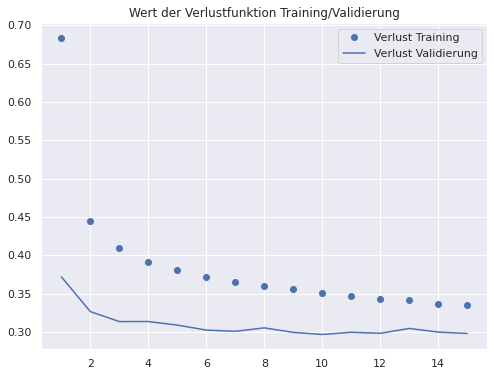

In [147]:
plot_train_val(history_lstm_32_odo)

## Lstm mit 64 ohne drop-out

In [148]:
lstm_64_odo = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64), #, return_sequences=True ), tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(units=1)
])

In [149]:
history_lstm_64_odo = compile_and_fit(lstm_64_odo, eingabe_window, patience=5)

IPython.display.clear_output()
val_performance['lstm_64_odo_' + label_ziel + "_"+ str(Stunden) + 'h'] = lstm_64_odo.evaluate(eingabe_window.val)

9/9 [==============================] - 1s 63ms/step - loss: 0.3048 - mean_absolute_error: 0.3881


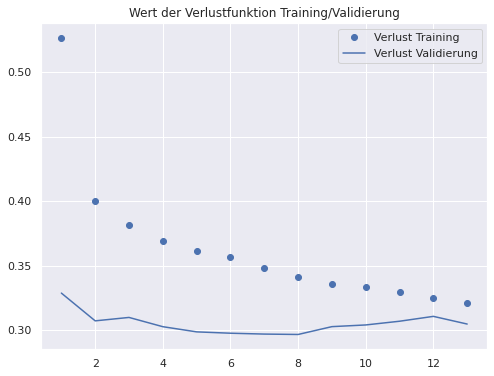

In [150]:
plot_train_val(history_lstm_64_odo)

## Lstm mit 32 + 16 ohne drop-out

In [151]:
lstm_32_16_odo = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True ), 
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(units=1)
])

In [152]:
history_lstm_32_16_odo = compile_and_fit(lstm_32_16_odo, eingabe_window, patience=5)

IPython.display.clear_output()
val_performance['lstm_32+16_odo_' + label_ziel + "_" + str(Stunden) + 'h'] = lstm_32_16_odo.evaluate(eingabe_window.val)

9/9 [==============================] - 1s 65ms/step - loss: 0.3053 - mean_absolute_error: 0.3906


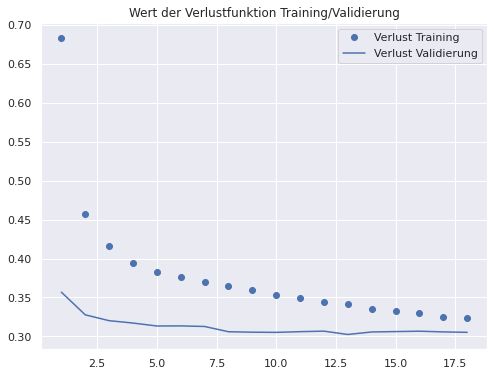

In [153]:
plot_train_val(history_lstm_32_16_odo)

## Ausgabe durchschnittlicher Fehler der trainierten Modelle

In [154]:
print(feature_auswahl)
for name, value in val_performance.items():
  print(f'{name:3}: {value[1]:0.4f}')

['Graz-N', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
vergleich_Graz-N_6h: 0.5529
lstm_32_odo_Graz-N_6h: 0.3838
lstm_64_odo_Graz-N_6h: 0.3881
lstm_32+16_odo_Graz-N_6h: 0.3906


## Speichern eines Modells zur Verwendung in der Runtime

In [155]:
lstm_64_odo.save('EA2-Modell')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: EA2-Modell/assets


## Schlusswort zu den trainierten Modellen

Bei der Umsetzung des Projekts wurden unterschiedlichste Anpassungen an den Modellen durchgeführt (drop-out layer, learning rate, batch size, etc.), welche aber allesamt zu keinen Verbesserungen geführt haben. Das ist hinsichtlich der Datenanalyse aber auch nachvollziehbar.

Interessant wäre es, mit einflussreicheren Daten, wie zum Beispiel Verkehrsdaten zu arbeiten. Aufgrund von Zeitmangel und dem Zustand von verfügbaren Daten aus diesem Bereich wurde das jedoch im Rahmen dieses Projekts nicht in Angriff genommen. Auch das Training von mehreren Modellen, welche jeweils für eine Station einen Vorhersagewert liefern, welche dann wiederum gemittelt werden, wäre eine schnelle Methode, die die Vorhersagen verbessern könnte. Während die Erstellung einer solchen Vorhersage nicht aufwändig wäre, hat der Umfang des Projekts die Entwicklung einer zuverlässigen Bewertungsmethode solcher Verhersagen nicht zugelassen (nachdem schon in den IoT-Pilotprojekt Daten sehr viel Aufwand verschwunden ist).